<a href="https://colab.research.google.com/github/vinagoros/dv_streamprocessing/blob/main/PS_Diogo_HelioV1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Streams 2022
## Trabalho realizado por Vinagre, D. (61745) e Girão, H. (61727) 

### TP1 - Air Quality Monitoring (airborne particulate matter)
-- version April 6 
 - updated to full dataset.

-- version April 8 
 - added code for spark streaming (unstructured)

-- version April 12
 - added a note to highlight the unstructured data
 format has the timestamp at the last position.

---
### Colab Setup

The goal of this project is to analyze data provided by a set of air quality sensors [sds011](https://aqicn.org/sensor/sds011/pt/). The sensors present in the dataset are located in Portugal, namely in the Lisbon metro area. Each sensor provides two values: measuring particles less than 10 µm (P1) and less than 2.5 µm (P2) in μg/m³.

The sensor data, spans the first half of 2020, and is streamed of Kafka. 

Each data sample has the following schema:

sensor_id | sensor_type | location | latitude | longitude | timestamp | P1 | P2
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| timestamp | float | float

In [ ]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 54.5 MB/s 


'/usr/local/lib/python3.7/dist-packages/pyspark'

In [3]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.1.0
KAFKA=kafka_2.13-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2022/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties

Formatting /tmp/kraft-combined-logs


---
### Setup (End)

### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092 
* The events are published to the `air_quality` topic
# * Events are published 3600x faster than realtime relative to the timestamp

### Spark Streaming (Structured) 

In [ ]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2022/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null

cd kafka-tp1-logsender
nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --topic air_quality  --speedup 3600 2> publisher-error.log > publisher-out.log &

In [ ]:
#@title 1. Find the time of day with the poorest air quality, for each location. Updated daily;
#@markdown  Presupostos \
#@markdown  1. Spark Stream Estruturado \ 
#@markdown  2. O Máximo diário é alcançado através do cálculo do valor máximo de média das observações diárias no intervalo horário\ 
#@markdown  3. 1 dia são 24 segundos. \ 
#@markdown  3. A particula P2 foi a considerada relevante para este caso. \ 
# =============================================================================================
# Created By  : Vinagre,D.,Girão,H.')
# Created Date: Sat April 30 18:54:00 PDT 2022')
# =============================================================================================
# =============================================================================================
#Libraries
# =============================================================================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def dumpBatchDF(df, epoch_id):
    df = df.orderBy('location','data','average',ascending=True)
    df2 = df.groupBy('data','location') \
            .agg(last(round('average',2)).alias('max'),last('window').alias('period'))\
            .orderBy('data','location',ascending=True)\
            .show(100, False)
    


spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

results = lines \
          .withWatermark('timestamp', '24 hours') \
          .groupBy( window( lines.timestamp, '1 hours', None), 'location') \
          .agg(avg('p2').alias('average'),first(to_date('timestamp')).alias('data'))
# =============================================================================================
# 24sec=1day
# =============================================================================================
query = results \
    .writeStream \
    .outputMode('update') \
    .trigger(processingTime='interval 24 seconds') \
    .foreachBatch( dumpBatchDF ) \
    .start()

query.awaitTermination(200)
query.stop()


+----------+--------+------+------------------------------------------+
|data      |location|max   |period                                    |
+----------+--------+------+------------------------------------------+
|2020-01-01|10161   |97.61 |{2020-01-01 18:00:00, 2020-01-01 19:00:00}|
|2020-01-01|13691   |47.43 |{2020-01-01 19:00:00, 2020-01-01 20:00:00}|
|2020-01-01|14857   |81.39 |{2020-01-01 00:00:00, 2020-01-01 01:00:00}|
|2020-01-01|14858   |156.56|{2020-01-01 00:00:00, 2020-01-01 01:00:00}|
|2020-01-01|19563   |37.08 |{2020-01-01 05:00:00, 2020-01-01 06:00:00}|
|2020-01-01|2332    |286.25|{2020-01-01 00:00:00, 2020-01-01 01:00:00}|
|2020-01-02|10161   |53.65 |{2020-01-02 20:00:00, 2020-01-02 21:00:00}|
|2020-01-02|13691   |27.26 |{2020-01-02 18:00:00, 2020-01-02 19:00:00}|
|2020-01-02|14857   |72.5  |{2020-01-02 21:00:00, 2020-01-02 22:00:00}|
|2020-01-02|14858   |112.57|{2020-01-02 21:00:00, 2020-01-02 22:00:00}|
|2020-01-02|19563   |59.12 |{2020-01-02 01:00:00, 2020-01-02 02:

In [ ]:
#@title 2. Find the average air quality, for each location. Updated hourly;
#@markdown  Presupostos \
#@markdown  1. Spark Stream Estruturado \ 
#@markdown  2. O Máximo diário é alcançado através do cálculo do valor máximo diário no intervalo do dia\ 
#@markdown  3. 1 hora é 1 segundo. \ 
#@markdown  3. A particula P2 foi a considerada relevante para este caso. \ 

# =============================================================================================
# Created By  : Vinagre,D.,Girão,H.')
# Created Date: Sat April 30 18:54:00 PDT 2022')
# =============================================================================================
# =============================================================================================
#Libraries
# =============================================================================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def dumpBatchDF(df, epoch_id):
    df = df.orderBy('data','location','average',ascending=True)\
            .select('data','location',round('average',2).alias('Daily average'))\
            .show(100, False)
    


spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

# =============================================================================================
# Contexto
# =============================================================================================
lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

results = lines \
          .withWatermark('timestamp', '24 hours') \
          .groupBy( window( lines.timestamp, '24 hours', None), 'location') \
          .agg(avg('p2').alias('average'),first(to_date('timestamp')).alias('data'))\
          .drop('window')
# =============================================================================================
# 1sec=1hour
# =============================================================================================
query = results \
    .writeStream \
    .outputMode('update') \
    .trigger(processingTime='interval 1 seconds') \
    .foreachBatch( dumpBatchDF ) \
    .start()

query.awaitTermination(200)
query.stop()

+----------+--------+-------------+
|data      |location|Daily average|
+----------+--------+-------------+
|2020-01-01|10161   |41.33        |
|2020-01-01|13691   |17.74        |
|2020-01-01|14857   |31.86        |
|2020-01-01|14858   |55.78        |
|2020-01-01|19563   |23.58        |
|2020-01-01|2332    |93.2         |
|2020-01-02|10161   |28.64        |
|2020-01-02|13691   |15.56        |
|2020-01-02|14857   |32.63        |
|2020-01-02|14858   |55.43        |
|2020-01-02|19563   |24.67        |
|2020-01-02|2332    |72.98        |
|2020-01-03|10161   |31.59        |
|2020-01-03|13691   |10.19        |
|2020-01-03|14857   |54.09        |
|2020-01-03|14858   |93.61        |
|2020-01-03|19563   |13.58        |
|2020-01-03|2332    |51.45        |
|2020-01-04|10161   |35.15        |
|2020-01-04|13691   |11.5         |
|2020-01-04|14857   |27.3         |
|2020-01-04|14858   |49.0         |
|2020-01-04|19563   |24.03        |
|2020-01-04|2332    |49.8         |
|2020-01-05|10161   |10.53  

### Spark Streaming (UnStructured) 

Latest Spark does not support Kafka sources with UnStructured Streaming.

The next cell publishes the dataset using a TCP server, running at port 7777. For this mode, there is no need to install or run Kafka, using the cell above.

The events are played faster than "realtime", at a 3600x speedup, such that 1 hour in terms of dataset timestamps is
sent in 1 second realtime, provided the machine is fast enough. As such, Spark Streaming window functions need to be sized accordingly, since a minibatch of 1 second will be
worth 1 hour of dataset events.

Each line sample has the following parts separated by blanks:

sensor_id | sensor_type | location | latitude | longitude | P1 | P2 | timestamp 
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| float | float | timestamp

In [4]:
#@title Start Socket-based Publisher
%%bash

git clone https://github.com/smduarte/ps2022.git 2> /dev/null > /dev/null || git -C ps2022 pull
cd ps2022/colab/socket-tp1-logsender/

nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --port 7777  --speedup 3600 2> /tmp/publisher-error.log > /tmp/publisher-out.log &

In [5]:
#@title 1. Find the time of day with the poorest air quality, for each location. Updated daily (3 days selected);
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

def custom_comparator(value_a,value_b):
  micro_5_a = value_a[2]
  micro_5_b = value_b[2]
  micro_20_a = value_a[1]
  micro_20_b = value_b[1]
  timestamp_a = value_a[0]
  timestamp_b = value_b[0]
  if micro_5_a > micro_5_b:
    return (timestamp_a, micro_20_a, micro_5_a)
  elif micro_5_a < micro_5_b:
    return (timestamp_b, micro_20_b, micro_5_b)
  else:
    if micro_20_a > micro_20_b:
      return (timestamp_a, micro_20_a, micro_5_a)
    else:
      return (timestamp_b, micro_20_b, micro_5_b)

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(24,24).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[2],(split_line[7],float(split_line[5]),float(split_line[6])))) \
    .reduceByKey(custom_comparator) \
    .map(lambda line: ('location ' + line[0], 'time of poorest air quality: ' + line[1][0], 'p1 value: ' + str(line[1][1]), 'p2 value: ' + str(line[1][2])))

  lines.pprint()
    
  ssc.start()
  ssc.awaitTermination(80)  
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-05-02 17:06:39
-------------------------------------------
('location 10161', 'time of poorest air quality: 2020-01-01T19:06:21', 'p1 value: 253.8', 'p2 value: 141.73')
('location 14857', 'time of poorest air quality: 2020-01-01T13:42:05', 'p1 value: 310.03', 'p2 value: 173.47')
('location 19563', 'time of poorest air quality: 2020-01-01T21:33:37', 'p1 value: 76.0', 'p2 value: 47.42')
('location 13691', 'time of poorest air quality: 2020-01-01T18:45:09', 'p1 value: 97.07', 'p2 value: 87.23')
('location 14858', 'time of poorest air quality: 2020-01-01T00:02:15', 'p1 value: 348.83', 'p2 value: 198.47')
('location 2332', 'time of poorest air quality: 2020-01-01T00:48:53', 'p1 value: 547.7', 'p2 value: 313.03')

-------------------------------------------
Time: 2022-05-02 17:07:03
-------------------------------------------
('location 14857', 'time of poorest air quality: 2020-01-02T21:40:52', 'p1 value: 272.35', 'p2 value: 113.93')
('

In [6]:
#@title 2. Find the average air quality, for each location. Updated hourly;
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


try:
  ssc = StreamingContext(spark.sparkContext,1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(1,1).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[2]+ " " + split_line[7][:13],((float(split_line[5]),float(split_line[6]), 1)))) \
    .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])) \
    .map(lambda line: ('location ' + line[0],'average p1 levels: ' + str(round(line[1][0]/line[1][2],2)),'average p2 levels: ' + str(round(line[1][1]/line[1][2],2))))

  lines.pprint()
    
  ssc.start()
  ssc.awaitTermination(48)  
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-05-02 17:07:39
-------------------------------------------
('location 13691 2020-01-01T00', 'average p1 levels: 35.11', 'average p2 levels: 22.82')
('location 10161 2020-01-01T00', 'average p1 levels: 118.25', 'average p2 levels: 75.01')
('location 14858 2020-01-01T00', 'average p1 levels: 304.91', 'average p2 levels: 180.23')
('location 14857 2020-01-01T00', 'average p1 levels: 231.15', 'average p2 levels: 102.25')

-------------------------------------------
Time: 2022-05-02 17:07:40
-------------------------------------------
('location 13691 2020-01-01T00', 'average p1 levels: 25.87', 'average p2 levels: 19.12')
('location 2332 2020-01-01T00', 'average p1 levels: 549.06', 'average p2 levels: 286.25')
('location 14857 2020-01-01T01', 'average p1 levels: 126.57', 'average p2 levels: 56.38')
('location 10161 2020-01-01T01', 'average p1 levels: 114.03', 'average p2 levels: 67.84')
('location 13691 2020-01-01T01', 'average p1 levels

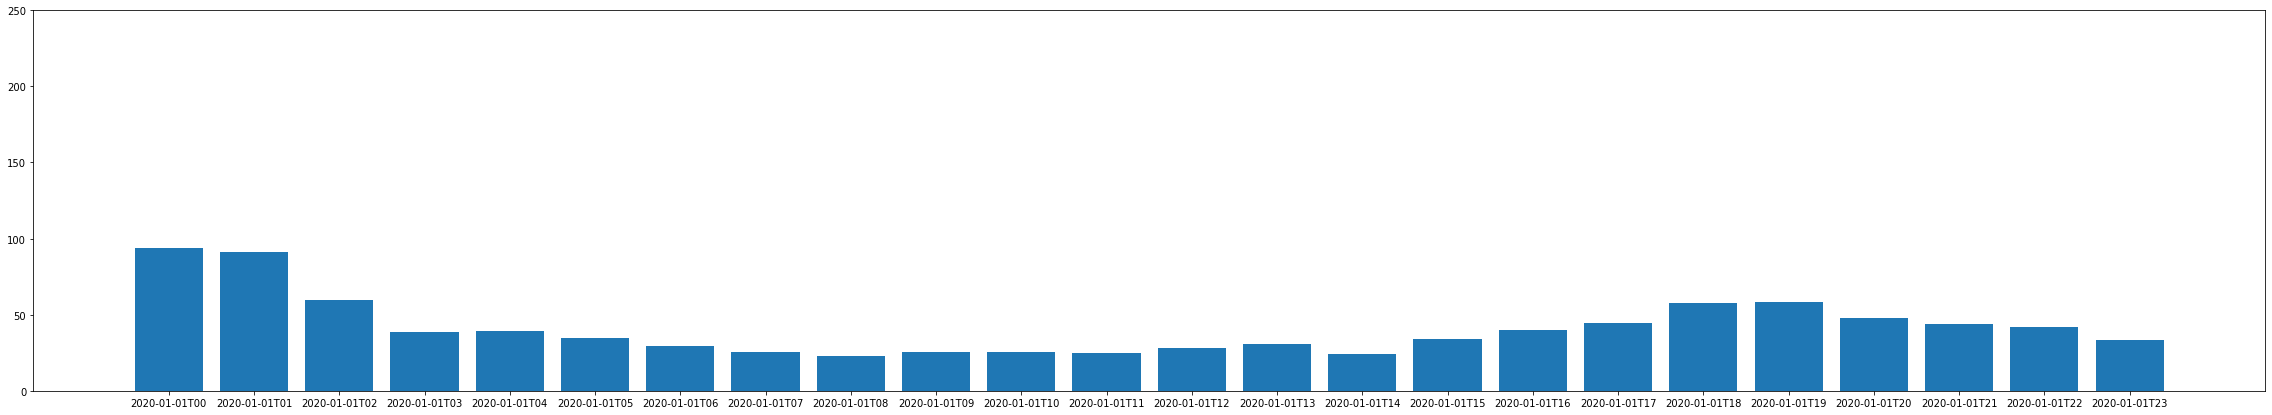

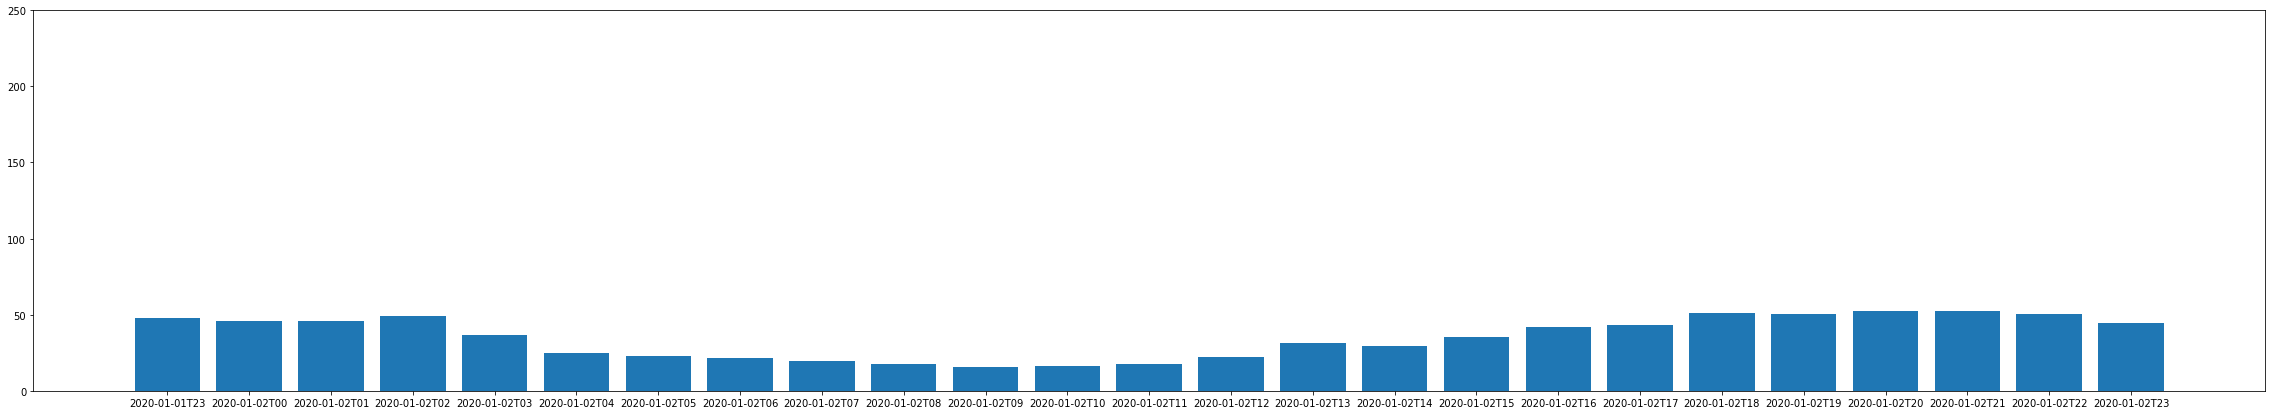

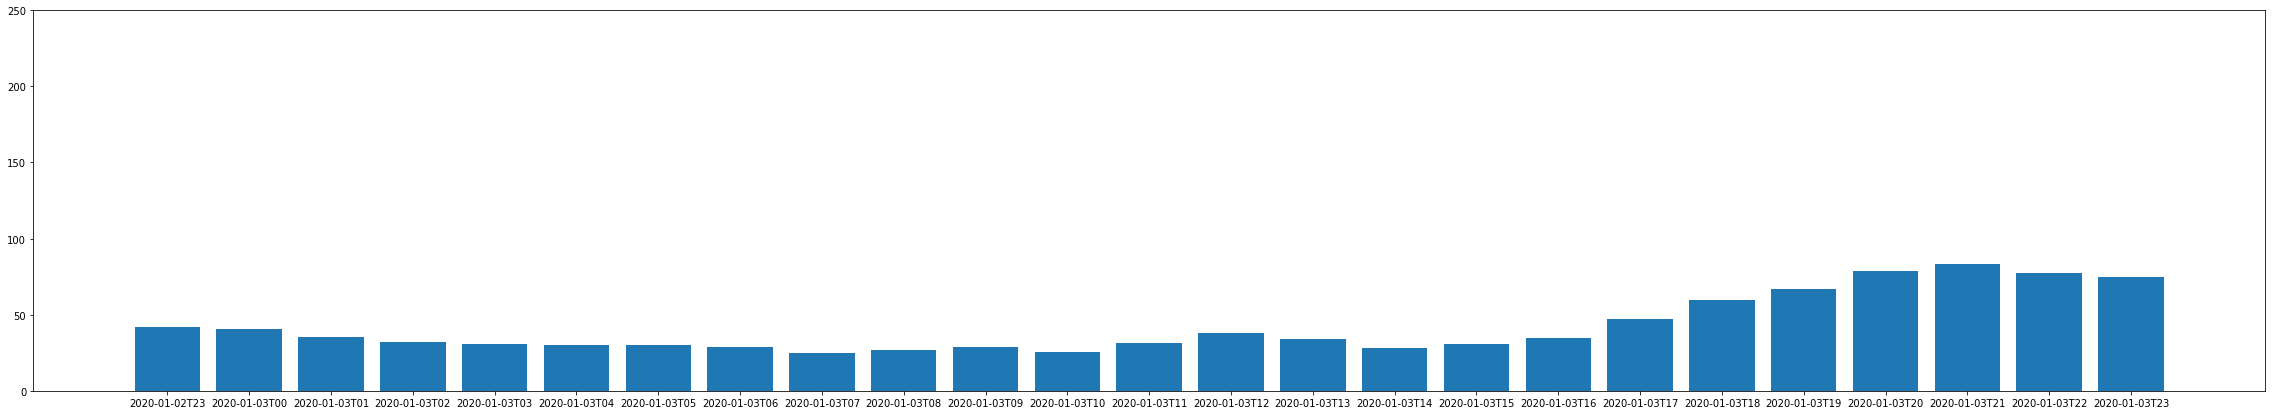

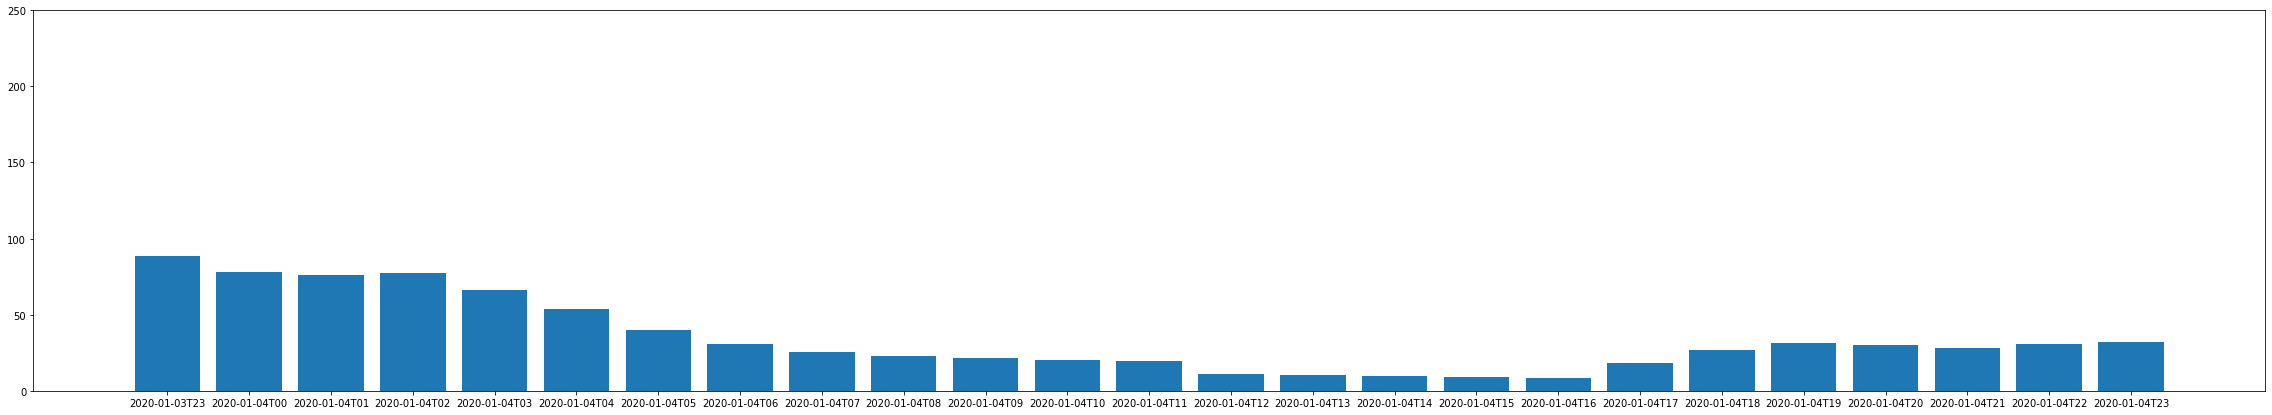

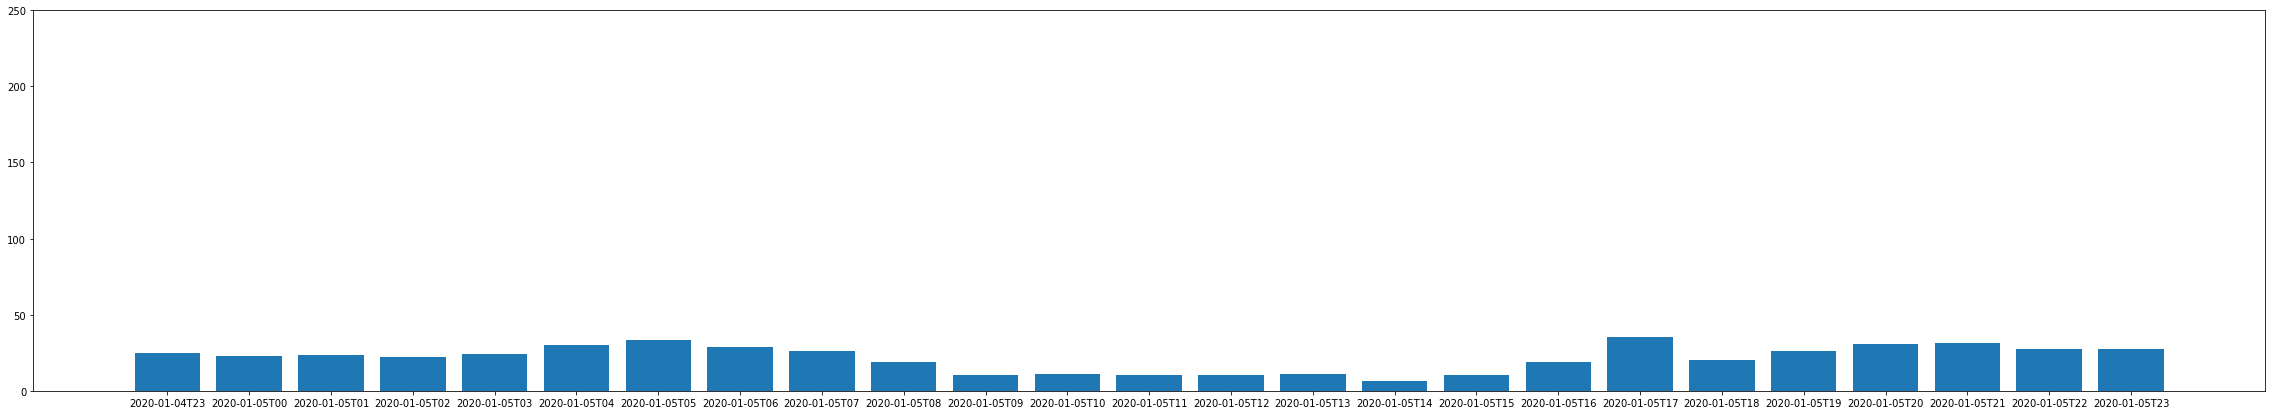

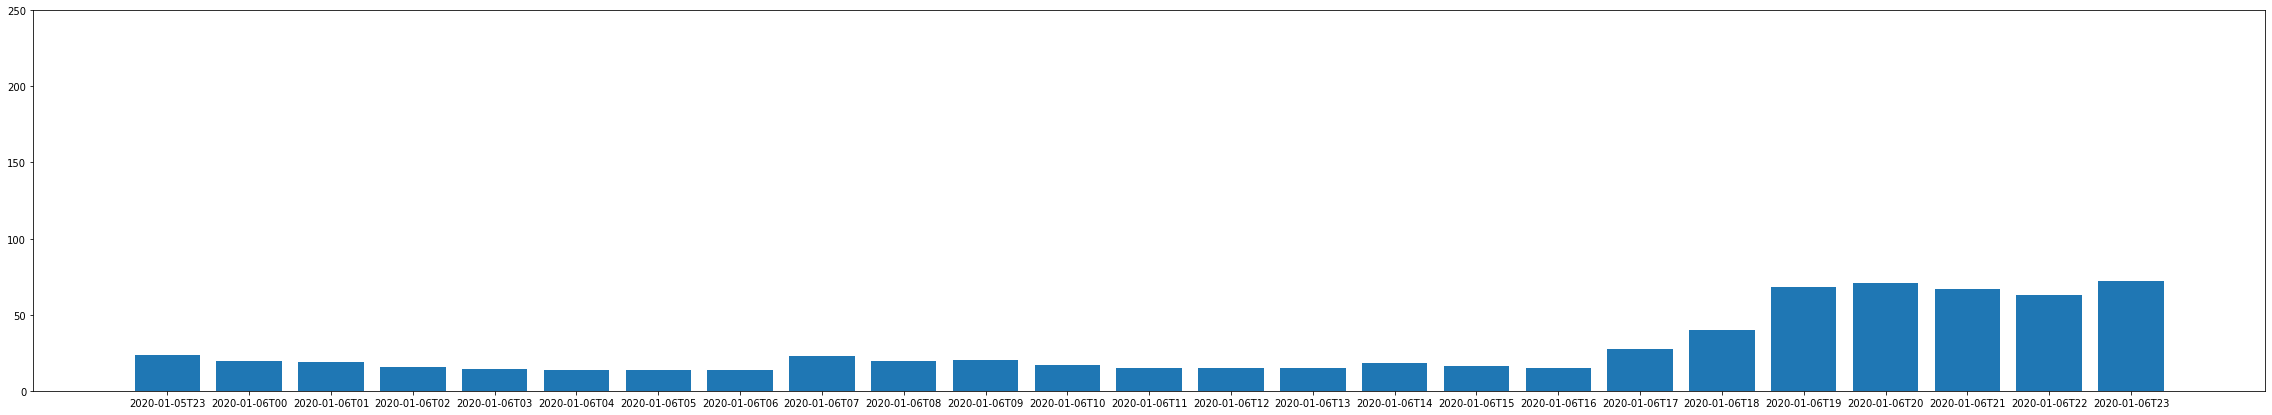

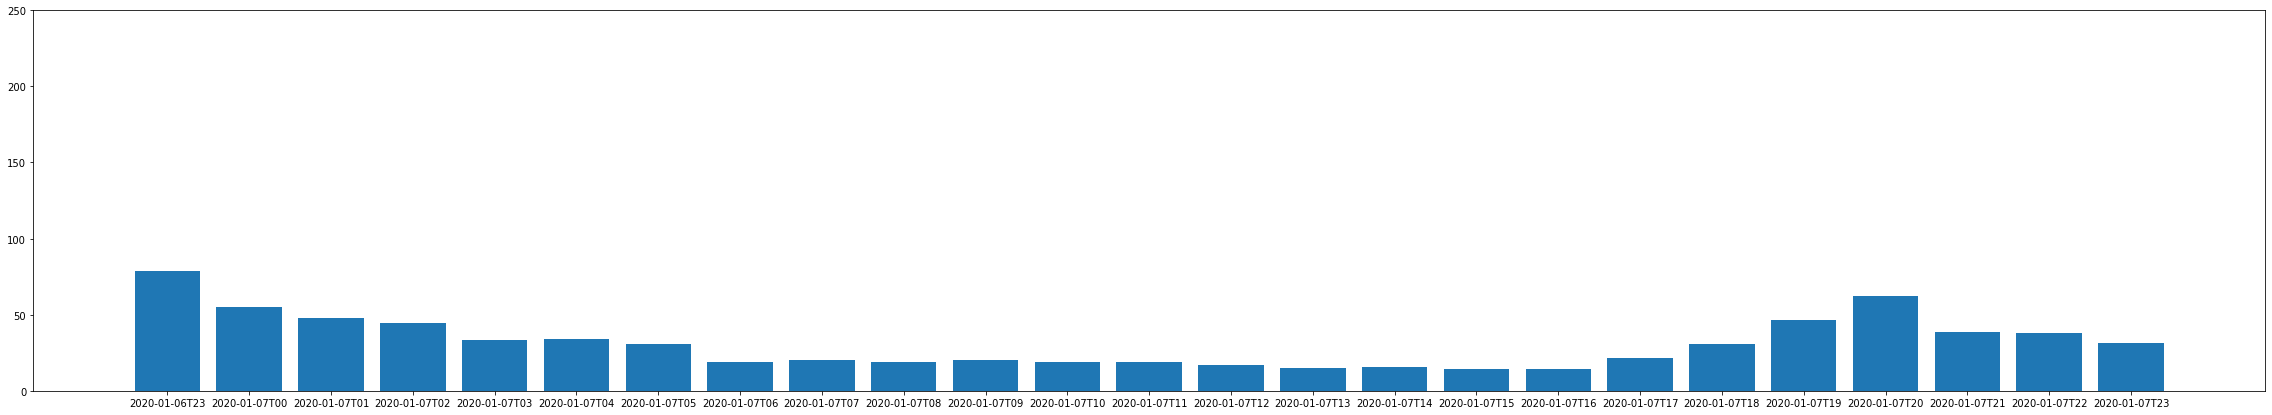

In [7]:
#@title 3.1.1 Can you show any daily and/or weekly patterns to air quality? Daily pattern (total p2 average for each time of day )

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from matplotlib import pyplot as plt
import numpy as np

def plot_rdd(rdd):
  sorted_rdd = rdd.sortBy(lambda keyvalue : keyvalue[0])
  a = np.array(sorted_rdd.collect())
  p_2 = a[:,2]
  p_2 = p_2.astype(float)
  location_hour = a[:,0]
  plt.figure(figsize=[40,7])
  plt.ylim(0,200)
  plt.bar(location_hour, p_2)
  plt.show()


spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(24,24).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[7][:13],(float(split_line[5]),float(split_line[6]), 1))) \
    .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])) \
    .map(lambda line: (line[0],float(line[1][0]/line[1][2]),float(line[1][1]/line[1][2]))) \
    .foreachRDD(plot_rdd)

  ssc.start()
  ssc.awaitTermination(25*7)  

except Exception as err:
  print(err)

ssc.stop()
spark.stop()


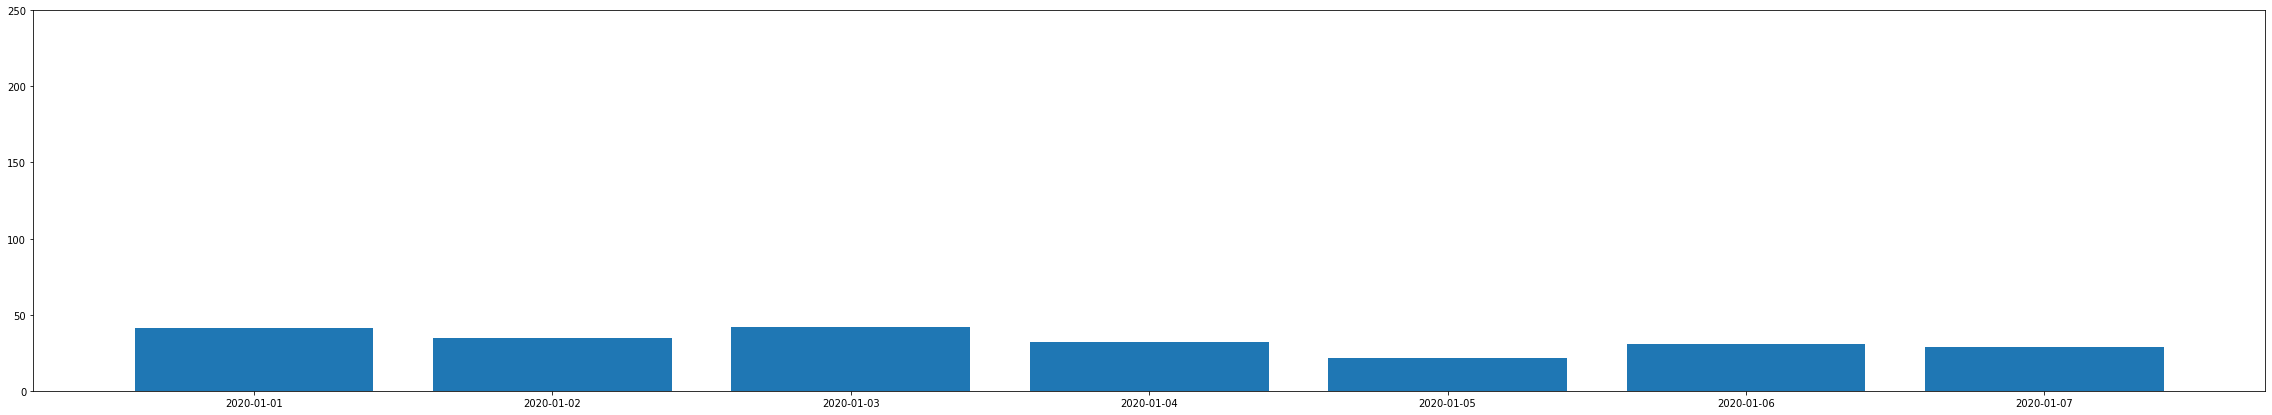

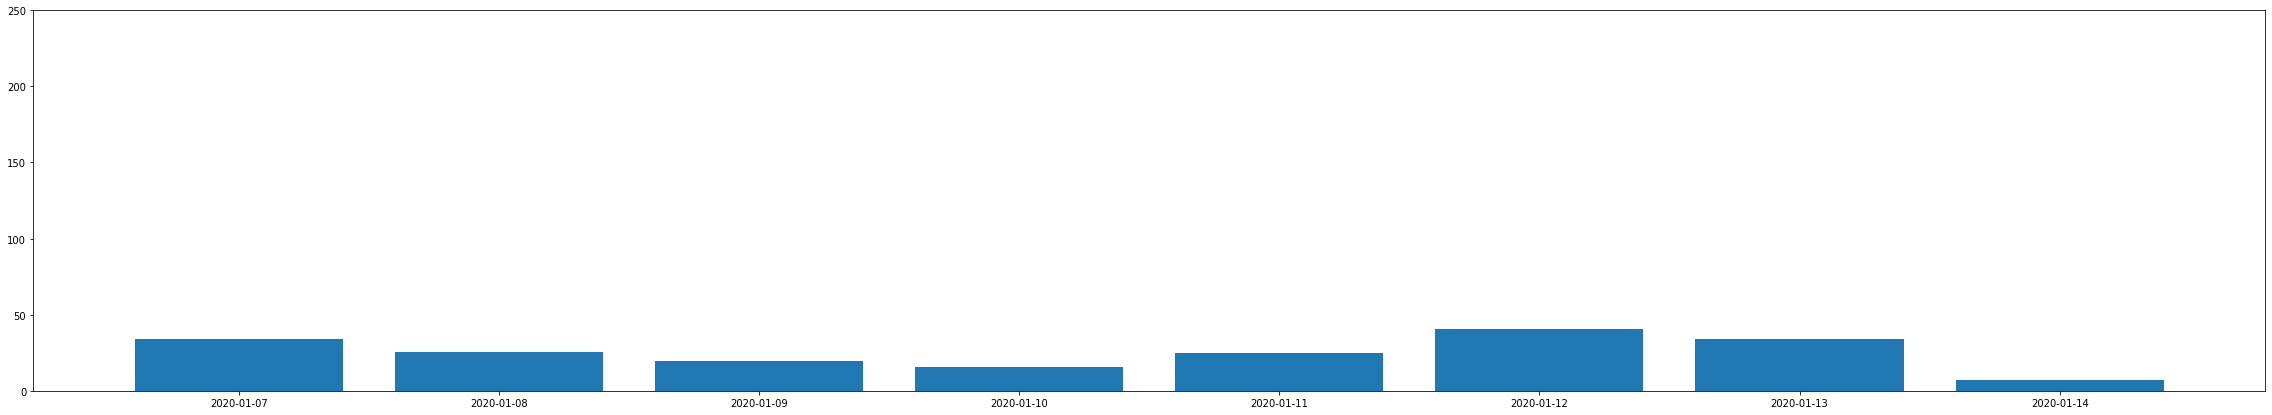

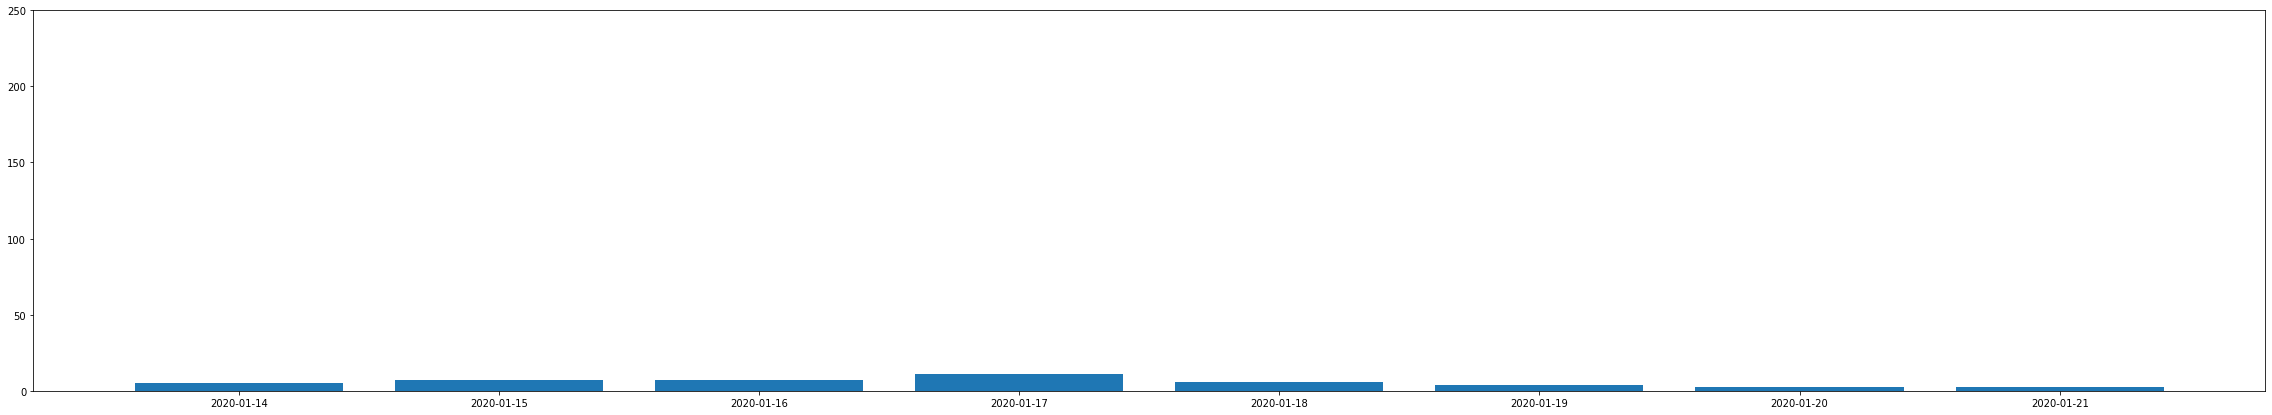

In [8]:
#@title 3.1.2 Can you show any daily and/or weekly patterns to air quality? Weekly pattern over 3 weeks (p2 average for each day )

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from matplotlib import pyplot as plt
import numpy as np


def plot_rdd(rdd):
  sorted_rdd = rdd.sortBy(lambda keyvalue : keyvalue[0])
  a = np.array(sorted_rdd.collect())
  p_2 = a[:,2]
  p_2 = p_2.astype(float)
  location_hour = a[:,0]
  plt.figure(figsize=[40,7])
  plt.ylim(0,200)
  plt.bar(location_hour, p_2)
  plt.show()


spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


try:
  
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(24*7,24*7).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[7][:10],(float(split_line[5]),float(split_line[6]), 1))) \
    .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])) \
    .map(lambda line: (line[0],float(line[1][0]/line[1][2]),float(line[1][1]/line[1][2]))) \
    .foreachRDD(plot_rdd)

  ssc.start()
  ssc.awaitTermination(25*21)  

except Exception as err:
  print(err)

ssc.stop()
spark.stop()

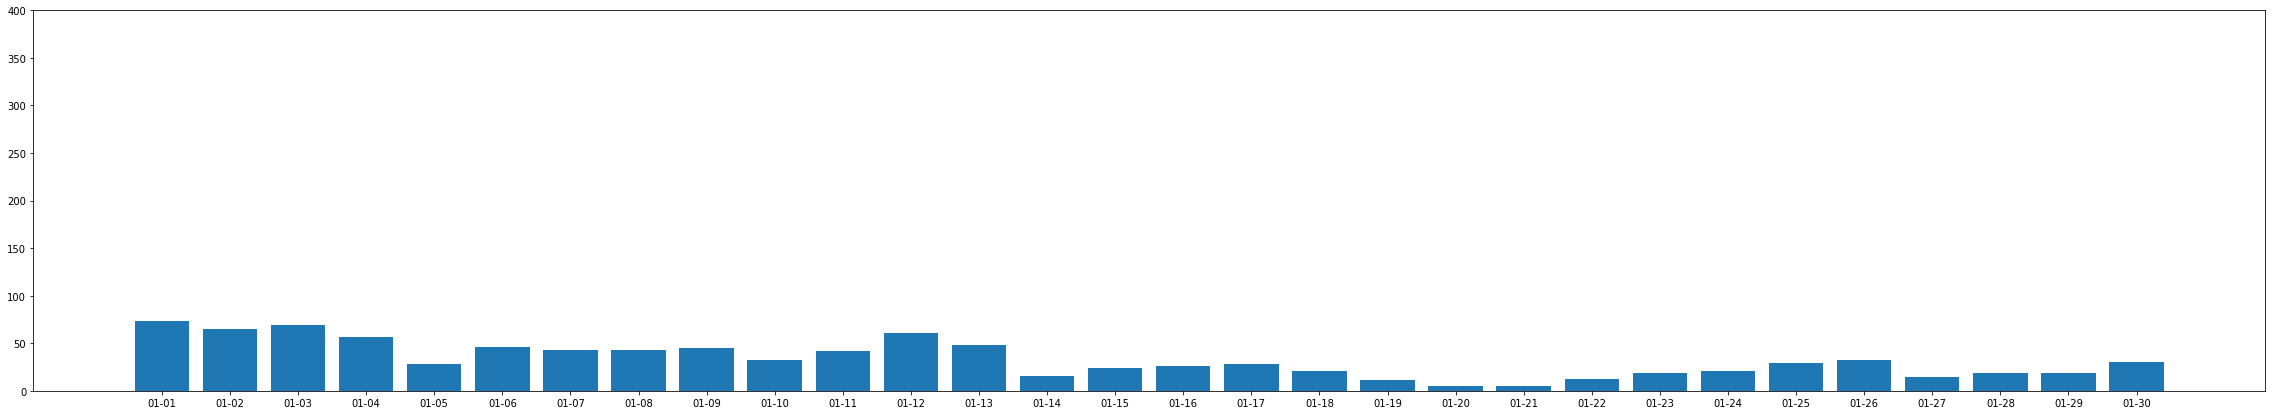

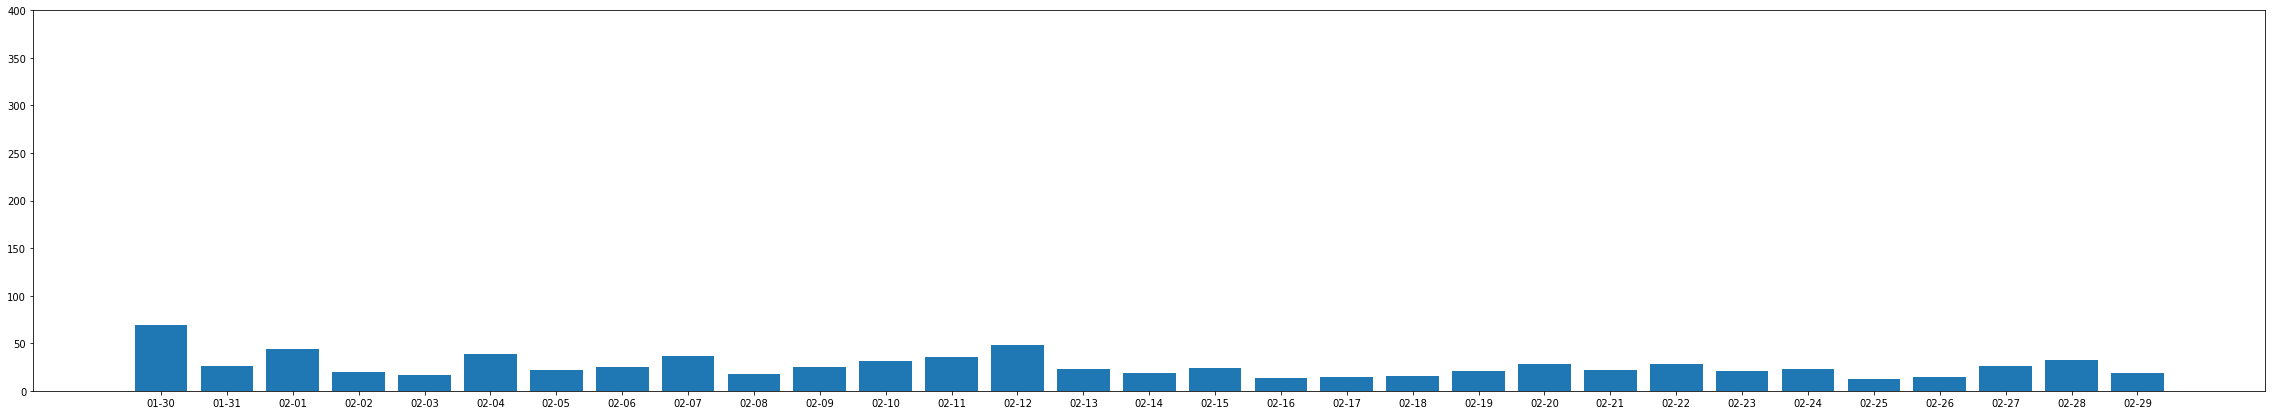

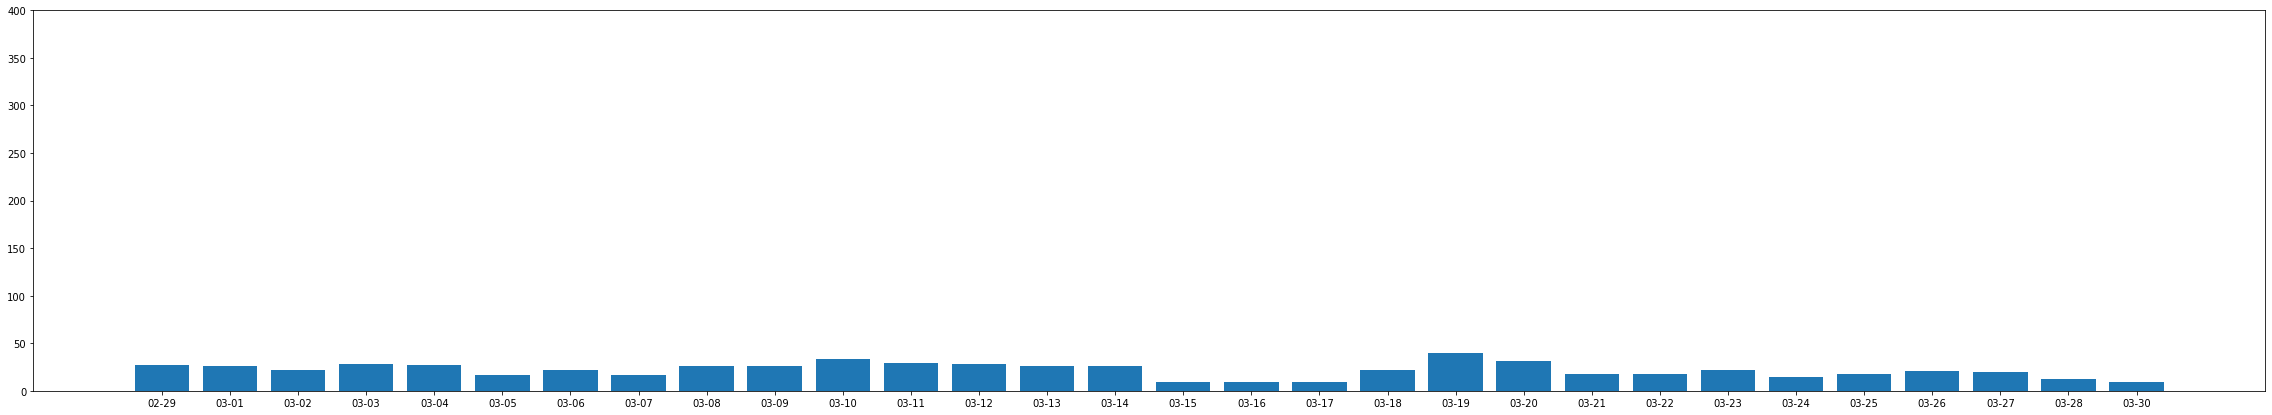

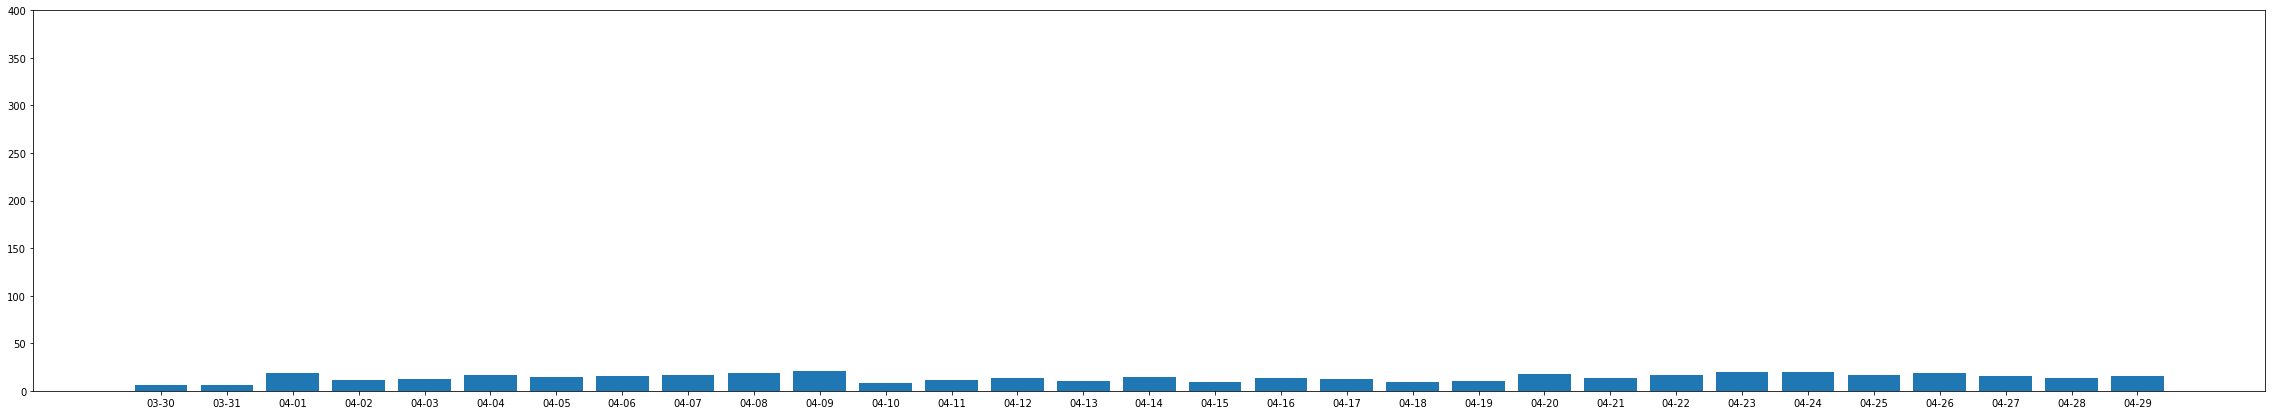

In [13]:
#@title 4.The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from matplotlib import pyplot as plt
import numpy as np



def spec_reducer_2(value_a,value_b):
  micro_5_a = value_a[0]
  micro_5_b = value_b[0]
  micro_20_a = value_a[1]
  micro_20_b = value_b[1]
  if micro_5_a > micro_5_b:
    return (micro_20_a, micro_5_a)
  elif micro_5_a < micro_5_b:
    return (micro_20_b, micro_5_b)
  else:
    if micro_20_a > micro_20_b:
      return (micro_20_a, micro_5_a)
    else:
      return (micro_20_b, micro_5_b)


def plot_rdd(rdd):
  sorted_rdd = rdd.sortBy(lambda keyvalue : keyvalue[0])
  a = np.array(sorted_rdd.collect())
  p_2 = a[:,1]
  p_2 = p_2.astype(float)
  location_hour = a[:,0]
  plt.figure(figsize=[40,7])
  plt.ylim(0,200)
  plt.bar(location_hour, p_2)
  plt.show()


spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


try:
  
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(24*30,24*30).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[7][5:10],(float(split_line[5]),float(split_line[6]), 1))) \
    .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])) \
    .map(lambda line: (line[0],float(line[1][0]/line[1][2]),float(line[1][1]/line[1][2]))) \
    .foreachRDD(plot_rdd)
  #lines.pprint()

  ssc.start()
  ssc.awaitTermination(24*30*5)  

except Exception as err:
  print(err)

ssc.stop()
spark.stop()

During confinement, the average daily air pollution is noticeably lower